In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 13})
import matplotlib.dates as mdates
import pandas as pd
# %matplotlib inline

#Dask
from dask.distributed import Client

client = Client()
client

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-93.5)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40223 instead
  warnings.warn(


In [2]:
#Parent grid - not associated with the child grid. 
paths = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver0/ocean_avg_0000*.nc')
ds_parent = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
ds_parent, grid_parent = xroms.roms_dataset(ds_parent, Vtransform = 2)

#Nested child grid
paths = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_00*.nc')
ds_child = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
ds_child, grid_child = xroms.roms_dataset(ds_child, Vtransform = 2)

# xisliceparent = slice(271,404)
# etasliceparent = slice(31,149)
# xislicechild = slice(8,677-8)
# etaslicechild = slice(8,602-8)

In [3]:
def surface_vorticity(ds, grid):
    '''
Calculates the surface vertical vorticity normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
rvort_psi: Normalized vorticity on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudy = grid.derivative(u, 'Y')
    dvdx = grid.derivative(v, 'X')
    f_psi = xroms.to_psi(ds.f, grid)

    rvort_psi = (dvdx-dudy)/f_psi
    
    return rvort_psi 

def surface_divergence(ds, grid):
    '''
Calculates the surface divergence normalized by the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
divergence: Normalized divergence on the rho points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudx = grid.derivative(u, 'X', boundary = 'extend')
    dvdy = grid.derivative(v, 'Y', boundary = 'extend')

    divergence = (dudx+dvdy)/ds.f 
    
    return divergence 

def surface_strain(ds, grid):
    '''
Calculates the surface strain normalized by the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
strain: Normalized strain on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudx = grid.derivative(u, 'X', boundary = 'extend')
    dudx_psi = xroms.to_psi(dudx, grid)
    dvdy = grid.derivative(v, 'Y', boundary = 'extend')
    dvdy_psi = xroms.to_psi(dvdy, grid)
    
    dudy = grid.derivative(u, 'Y')
    dvdx = grid.derivative(v, 'X')
    
    f_psi = xroms.to_psi(ds.f, grid)
    strain = (((dudx_psi-dvdy_psi)**2+(dvdx+dudy)**2)**(1/2))/f_psi
    
    return strain

def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points

    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_psi(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_psi(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

In [4]:
model_time = datetime(2010,6,20,12,30)

rvort = surface_vorticity(ds_parent, grid_parent).sel(ocean_time = model_time).load()
divergence = surface_divergence(ds_parent, grid_parent).sel(ocean_time = model_time).load()
strain_psi = surface_strain(ds_parent, grid_parent).sel(ocean_time = model_time).load()
sgradmag = surface_saltgradmag(ds_parent, grid_parent).sel(ocean_time = model_time).load()

# rvort_parent_nested = surface_vorticity(ds_parent_nested, grid_parent_nested).sel(ocean_time = model_time).load()
# divergence_parent_nested = surface_divergence(ds_parent_nested, grid_parent_nested).sel(ocean_time = model_time).load()
# strain_psi_parent_nested = surface_strain(ds_parent_nested, grid_parent_nested).sel(ocean_time = model_time).load()
# sgradmag_parent_nested = surface_saltgradmag(ds_parent_nested, grid_parent_nested).sel(ocean_time = model_time).load()

rvort_child = surface_vorticity(ds_child, grid_child).sel(ocean_time = model_time).load()
divergence_child = surface_divergence(ds_child, grid_child).sel(ocean_time = model_time).load()
strain_psi_child = surface_strain(ds_child, grid_child).sel(ocean_time = model_time).load()
sgradmag_child = surface_saltgradmag(ds_child, grid_child).sel(ocean_time = model_time).load()

sss_parent = ds_parent.salt.isel(s_rho = -1).sel(ocean_time = model_time).load()
# sss_parent_nested = ds_parent_nested.salt.isel(s_rho = -1).sel(ocean_time = model_time).load() 
sss_child = ds_child.salt.isel(s_rho = -1).sel(ocean_time = model_time).load() 

In [8]:
mnum = ds_parent.dye_03.isel(s_rho = -1).sel(ocean_time = model_time).load()
mnum_child = ds_child.dye_03.isel(s_rho = -1).sel(ocean_time = model_time).load()

In [5]:
import matplotlib.ticker as tick
ticks = [-6, -5, -4, -3, -2], format=tick.FormatStrFormatter('$10^{%d}$')

SyntaxError: cannot assign to operator (3987286942.py, line 2)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/tmp/ipykernel_8506/3567591159.py:175: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()


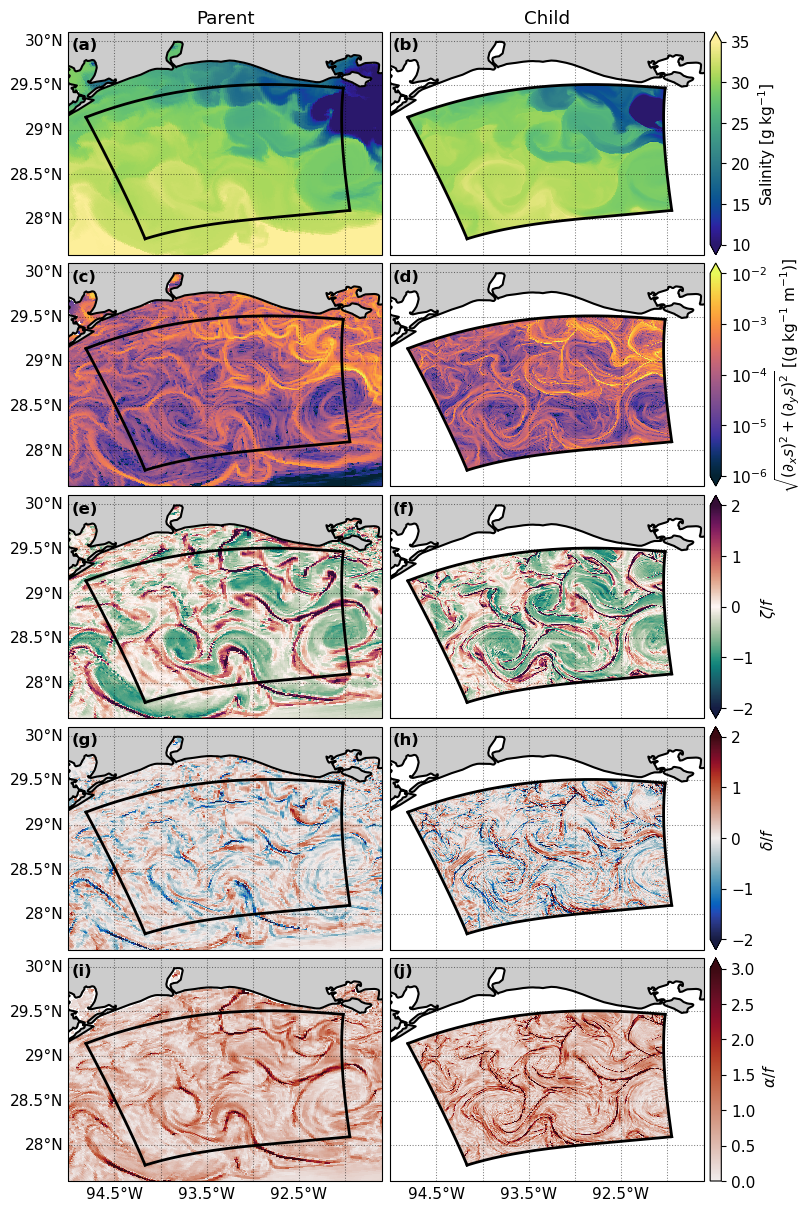

In [6]:
plt.rcParams.update({'font.size': 11})
ncols = 2
nrows = 5
import matplotlib.ticker as tick



fig,ax = plt.subplots(nrows,ncols,figsize=(8,12),dpi = 100, subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax[0,0].pcolormesh(ds_parent.lon_rho,
                            ds_parent.lat_rho,
                            sss_parent, 
                            cmap = cmo.haline,
                            vmin = 10,
                            vmax = 35,
                            transform = ccrs.PlateCarree())

mappable1 = ax[0,1].pcolormesh(ds_child.lon_rho,
                            ds_child.lat_rho,
                            sss_child, 
                            cmap = cmo.haline,
                            vmin = 10,
                            vmax = 35,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable1, ax = ax[0,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.02)
cb.set_label(r'Salinity [g kg$^{-1}$]')

mappable2 = ax[1,0].pcolormesh(ds_parent.lon_psi,
                            ds_parent.lat_psi,
                            np.log10(sgradmag), 
                            cmap = cmo.thermal,
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())
mappable3 = ax[1,1].pcolormesh(ds_child.lon_psi,
                            ds_child.lat_psi,
                            np.log10(sgradmag_child), 
                            cmap = cmo.thermal,
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())


cb = fig.colorbar(mappable3, ax = ax[1,1], orientation = 'vertical',  
                  ticks = [-6, -5, -4, -3, -2], format=tick.FormatStrFormatter('$10^{%d}$'),
                  extend = 'both', pad = 0.02)
cb.set_label(r'$\sqrt{(\partial_x s)^2 + (\partial_y s)^2}$ [(g kg$^{-1}$ m$^{-1}$)]')

mappable4 = ax[2,0].pcolormesh(ds_parent.lon_psi,
                             ds_parent.lat_psi,
                             rvort, 
                             cmap = cmo.curl,
                             vmin = -2,
                             vmax = 2,
                             transform = ccrs.PlateCarree())
mappable5 = ax[2,1].pcolormesh(ds_child.lon_psi,
                             ds_child.lat_psi,
                             rvort_child, 
                             cmap = cmo.curl,
                             vmin = -2,
                             vmax = 2,
                             transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable5, ax = ax[2,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.02)
cb.set_label(r'$\zeta/f$')

mappable6 = ax[3,0].pcolormesh(ds_parent.lon_rho,
                            ds_parent.lat_rho,
                            divergence, 
                            cmap = cmo.balance,
                            vmin = -2,
                            vmax = 2,
                            transform = ccrs.PlateCarree())
mappable7 = ax[3,1].pcolormesh(ds_child.lon_rho,
                            ds_child.lat_rho,
                            divergence_child, 
                            cmap = cmo.balance,
                            vmin = -2,
                            vmax = 2,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable7, ax = ax[3,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.02)
cb.set_label(r'$\delta/f$')

mappable8 = ax[4,0].pcolormesh(ds_parent.lon_psi,
                             ds_parent.lat_psi,
                             strain_psi, 
                             cmap = cmo.amp,
                             vmin = 0,
                             vmax = 3,
                             transform = ccrs.PlateCarree())
mappable9 = ax[4,1].pcolormesh(ds_child.lon_psi,
                             ds_child.lat_psi,
                             strain_psi_child, 
                             cmap = cmo.amp,
                             vmin = 0,
                             vmax = 3,
                             transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable9, ax = ax[4,1], orientation = 'vertical', 
                  extend = 'max', pad = 0.02)
cb.set_label(r'$\alpha/f$')

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].coastlines(resolution='10m', linewidth = 1.5)  
        ax[i,j].set_aspect('auto')
        ax[i,j].plot(ds_child.lon_rho[0,:], 
                     ds_child.lat_rho[0,:], 
                     'k', lw=2,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_child.lon_rho[:,0], 
                     ds_child.lat_rho[:,0], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(ds_child.lon_rho[:,-1], 
                     ds_child.lat_rho[:,-1], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(ds_child.lon_rho[-1,:], 
                     ds_child.lat_rho[-1,:], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
for i in range(nrows-1):
    gl = ax[i,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)
    gl = ax[i,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.left_labels = True
    gl.top_labels = False
    gl.bottom_labels = False

gl = ax[4,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[4,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[0,0].set_title('Parent')
ax[0,1].set_title('Child')

ax[0,0].annotate('(a)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[0,1].annotate('(b)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[1,0].annotate('(c)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[1,1].annotate('(d)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[2,0].annotate('(e)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[2,1].annotate('(f)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[3,0].annotate('(g)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[3,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[3,1].annotate('(h)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[3,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[4,0].annotate('(i)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[4,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[4,1].annotate('(j)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[4,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
fig.canvas.draw()

# plt.savefig('/d2/home/dylan/JAMES/figures/surface_comparison.jpg', dpi = 300, bbox_inches='tight')